<h1><center>Определение выгодного тарифа для телеком компании</center></h1>

---

## Описание данных

Таблица `users` (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица `calls` (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Имопрт и загрузка

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats as st
from scipy.stats import norm
import math as mt

In [54]:
users = pd.read_csv('../../datasets/chapter_04_project_users.csv')
calls = pd.read_csv('../../datasets/chapter_04_project_calls.csv')
messages = pd.read_csv('../../datasets/chapter_04_project_messages.csv')
internet = pd.read_csv('../../datasets/chapter_04_project_internet.csv')
tariffs = pd.read_csv('../../datasets/chapter_04_project_tariffs.csv')

##  Предобработка данных

Цель данного блока работы:
- Найти и исправить ошибки в даных: привести к нужным типам, обработать пропуски и т.д.
- Подготовить информацию для дальнейшего анализа. Посчитать для каждого пользователя:
- - количество сделанных звонков и израсходованных минут разговора по месяца
- - количество отправленных сообщений по месяцам;
- - объем израсходованного интернет-трафика по месяцам;
- - помесячную выручку с каждого пользователя

### таблица `users`

In [55]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [56]:
users.tail()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


Первые выводы по данным в таблице:
- `churn_date` нужно привести к типу дата, чтобы была возможность работать с временными интервалами. Так же надо заменить NaN на что-то другое, например на -1 или 0. Но поскольку в задаче не требуется анализировать время оттока пользователей, то пока не буде обрабатывать данные NaN. Делаю это, чтобы быстрее выполнить проект. Если же такая информация потребуется (по ходу проекта), то добавлю.
- `city`, `first_name`, `last_name`, `tarif` приведу к единому регистру написания, с маленькой буквы. Сделаю это чтобы исключить возможность разного написания и дублирования информации. 
- `reg_data` так же надо привести к формату дата 

In [57]:
def my_date(data, *columns):
    '''
    Функция принимает DataFrame и названия столбцов в которых нужно заменить тип данных на datetime64.
    В случае ошибки должно быть предупреждение, что что-то сломалось 
    '''
    for column in columns:    
        try:
            data.loc[:, column] = pd.to_datetime(data[column], format='%Y-%m-%d')
        except:
            print('Что-то пошло не так')

In [58]:
# Меняю тип данных на datetime
my_date(users, 'reg_date', 'churn_date')

In [59]:
def my_lower(data, *columns):
    '''
    Функция принимает DataFrame и названия столбцов в которых нужно произвести замену.
    В случае ошибки должно быть предупреждение, что что-то сломалось 
    '''
    
    for column in columns:
        try:
            data[column] = data[column].str.lower()  
        except:
            print('Что-то пошло не так')

In [60]:
# Привожу данные к единому регистру
my_lower(users, 'city', 'first_name', 'last_name', 'tariff')

In [61]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Отлично, преобразования типов сделаны. Функции отработали как и задумано.

Чтобы в дальнейшем было удобно сравнивать количество пользователей в разных таблицах (`calls`, `messages`, `internet`) сохраню в константу (условную) количество уникальных `user_id` из данной таблицы. 

In [62]:
USERS_COUNT = len(users['user_id'].unique())

In [63]:
def my_check_user_id(data, column):
    '''
    Функция принимает DataFrame и название столбца с user_id. 
    Проверяет количество уникальных значений и сравнивает с количеством user_id в таблице users
    '''
    target = len(data[column].unique())
    result = target - USERS_COUNT
    if result < 0:
        print('В таблице не хватает {} уникальных user_id'.format(result))
    else:
        print('В таблице перебор {} уникальных user_id'.format(result))

### таблица `calls`

In [64]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [65]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [66]:
# Сравниваю количество уникальных user_id 
my_check_user_id(calls, 'user_id')

В таблице не хватает -8 уникальных user_id


In [67]:
def my_abnormal(data, column, number):
    '''
    Функция принимает DataFrame, название столбца и значение с которым надо сравнивать данные в столбце.
    Возвращает количество записей <= и >= указанного значения и их % в данном столбце.
    '''
    total = len(data[column])

    count_down = len(data[data[column] <= number])
    percent_down = count_down / total
    
    count_up = len(data[data[column] >= number])
    percent_up = count_up / total
    
    return print('Количество {} в DataFrame\n'
                 '<= {:,}: {}. Доля таких значений {:.2%}\n'
                 '>= {:,}: {}. Доля таких значений {:.2%}'.format(column, number, count_down, 
                                                               percent_down, number, count_up, percent_up))

In [68]:
my_abnormal(calls, 'duration', 0)

Количество duration в DataFrame
<= 0: 39613. Доля таких значений 19.55%
>= 0: 202607. Доля таких значений 100.00%


Первые выводы по данным в таблице:
- `call_date` нужно привести к типу дата, чтобы была возможность работать с временными интервалами.
- `duration` так как "Мегалайн" округляет до 1 минуты даже разговор в 1 секунду, то и мне стоит округлить все дробные значения до целых. И чтобы уменьшить объем данных можно еще и тип поменять на int. По поводу записей с длительность разговора в 0 секунд. Здесь либо какая-то ошибка ввода данных, либо 20% пользователей вообще не звонят. Теоретически это возможно, но хочется рассмотреть вопрос более предметно. 
- `user_id` данная таблица содержит на 8 уникальных user_id меньше чем таблица `users`. Пока трудно сказать почему есть эти потери. Предварительно все похоже на ошибку в данных. Если бы данные пользователи вообще никогда не звонили, то у них был бы 0 в `duration`

In [69]:
# меняю тип данных на datetime
my_date(calls, 'call_date')

In [70]:
# округляю значения до целых и меняю тип данных
calls.loc[:, 'duration'] = pd.np.ceil(calls['duration'])
calls.loc[:, 'duration'] = calls['duration'].astype('int64')

<ipython-input-70-15d7869a2278>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  calls.loc[:, 'duration'] = pd.np.ceil(calls['duration'])


Добавлю дополнительные столбы из даты. В дальнейшем надо будет, как минимум, анализировать динамику по месяцам, так что эта информация явно пригодится

In [71]:
def my_add_date(data, column):
    '''
    Функция принимает DataFrame и название столбца с датой. "разбирает" дату на части (год, месяц, день, день недели) 
    и создает соответствующие столбцы в DataFrame
    '''
    data.loc[:, 'year'] = data[column].dt.year
    data.loc[:, 'month'] = data[column].dt.month
    data.loc[:, 'day'] = data[column].dt.day
    data.loc[:, 'weekday'] = data[column].dt.day_name().str.lower()

In [72]:
my_add_date(calls, 'call_date')

Попробую разобраться с записями у которых `duration == 0`. Логика рассуждений следующая:
1. Если в таблице `calls` есть запись звонка и у записи есть дата совершения звонка (дата != 0/NaN) + есть id звонка, значит такой звонок состоялся.
2. Чтобы понять что происходит надо посмотреть динамику появления записей `duration == 0`. Например, по месяцам.

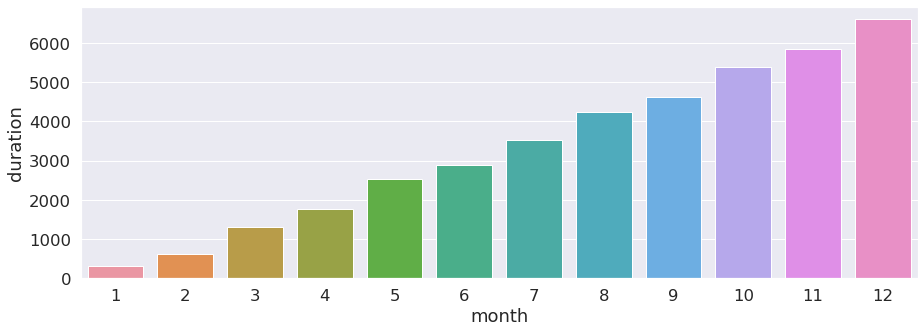

In [73]:
# собираю сводную таблицу
calls_table_duration = (
    calls[calls['duration']==0]
    .pivot_table(index='month', aggfunc={'duration':'count'})
    .reset_index()
)

# вывожу график
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
sns.barplot(x='month', y='duration',data=calls_table_duration);

Посмотрю распределение звонков по округленным длительностям

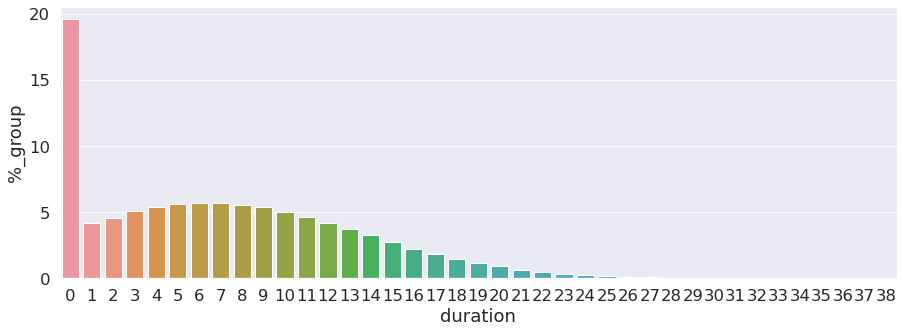

In [74]:
# собираю сводную таблицу
calls_table_duration_group = (calls
                              .pivot_table(index='duration', values='user_id', aggfunc='count')
                              .reset_index()
                             )

# считаю долю в звонков в каждой группе
calls_table_duration_group['%_group'] = round((calls_table_duration_group['user_id'] /  len(calls)) * 100, 4)

# вывожу график
sns.set_style('darkgrid')
plt.figure(figsize=(15, 5))
sns.barplot(x='duration', y='%_group',data=calls_table_duration_group);

Итог данного расследования - `duration == 0` это ошибка и ошибка технического характера. Делаю такое заключение так как:
- каждый месяц идет стабильный прирост количества звонков с нулевой длительностью. Что-то явно происходит не так и система теряет данные о части (существенной) звонков. 
- доля таких звонков  сильно выше чем в группах других длительностей.
- думаю, что данные нули надо заменить на медиану длительности звонка. Но прежде чем это сделать я хочу обработать остальные вводные данные. Может быть все дело в тарифе? Поэтому пока оставлю значения как есть, но буду помнить про данную аномалию.

### таблица `messages`

In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [25]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [26]:
my_check_user_id(messages, 'user_id')

В таблице не хватает -74 уникальных user_id


Первые выводы по данным в таблице:
- `message_date` нужно привести к типу дата, чтобы была возможность работать с временными интервалами.
- `user_id` данная таблица содержит на 74 уникальных user_id меньше чем таблица `users`. Пока трудно сказать почему есть эти потери. 

In [27]:
# меняю тип данных на datetime
my_date(messages, 'message_date')

# добавлю вспомогательное поле для группировки по месяцам 
messages.loc[:, 'msg_month'] = messages['message_date'].dt.month

# добавляю вспомогательные данные по дате
my_add_date(messages, 'message_date')

### таблица `internet`

In [28]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [29]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [30]:
my_check_user_id(internet, 'user_id')

В таблице не хватает -3 уникальных user_id


Первые выводы по данным в таблице:
- `Unnamed: 0` продублировался индекс при выгрузке даных в csv. Уберу данный столбец
- `session_date` нужно перевести в datetime
- `user_id` данная таблица содержит на 3 уникальных user_id меньше чем таблица `users`. Пока трудно сказать почему есть эти потери.

In [31]:
# удаляю лишний столбец
internet = internet[['id', 'mb_used', 'session_date', 'user_id']]

# меняю тип данных на datetime
my_date(internet, 'session_date')

# добавляю вспомогательные данные по дате
my_add_date(internet, 'session_date')

### таблица `tariffs`

In [32]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица заполнена корректно. Ничего исправлять не надо, но так как в дальнейшем придется использовать значения из таблицы тарифы (для вычислений), то переименую столбцы

In [33]:
tariffs.columns = ['msg_incl', 'mb_incl', 'minutes_incl',
       'rub_fee', 'per_gb', 'per_msg', 'per_minute',
       'tariff']

### расчеты по пользователям

Первым делом сведу фактические данные по пользователям в единую таблицу. 

In [34]:
def my_pivot_table(calls, messages, internet):
    '''
    Функция принимает таблицы на вход и отдает итоговую таблицу по user_id
    '''
    # сводная таблица по calls
    calls_table = calls.pivot_table(index=['user_id', 'month'],
                           aggfunc={'id':['count'], 'duration':['sum']}) 
    
    
    # сводная таблица по messages
    messages_table = messages.pivot_table(index=['user_id', 'month'],
                                         aggfunc={'id':['count']})
    
    
    # сводная таблица по internet
    internet_table = internet.pivot_table(index=['user_id', 'month'],
                                         aggfunc={'mb_used':['sum']})
    
    # меняю названия столбцов
    calls_table.columns = ['call_dur','call_count']
    messages_table.columns = ['msg_count']
    internet_table.columns = ['mb_used']
    
    
    # собираю промежуточные таблицы 
    merge_table = (calls_table
                    .merge(messages_table, on=['user_id', 'month'], how='left')
                    .merge(internet_table, on=['user_id', 'month'], how='left')
                    .reset_index()
                    )
    
    # объединяю с таблицей users и добавляю константы по тарифам 
    target_table = (users[['user_id', 'tariff']]
                    .merge(merge_table, on='user_id')
                    .merge(tariffs, on='tariff'))
    
    return target_table

In [35]:
user_by_month = my_pivot_table(calls, messages, internet)

In [36]:
user_by_month.head()

,user_id,tariff,month,call_dur,call_count,msg_count,mb_used,msg_incl,mb_incl,minutes_incl,rub_fee,per_gb,per_msg,per_minute
0,1000,ultra,5,159,22,22.0,2253.49,1000,30720,3000,1950,150,1,1
1,1000,ultra,6,172,43,60.0,23233.77,1000,30720,3000,1950,150,1,1
2,1000,ultra,7,340,47,75.0,14003.64,1000,30720,3000,1950,150,1,1
3,1000,ultra,8,408,52,81.0,14055.93,1000,30720,3000,1950,150,1,1
4,1000,ultra,9,466,58,57.0,14568.91,1000,30720,3000,1950,150,1,1


Теперь можно посчитать прибыль по каждому пользователю в разрезе по месяцам.

In [37]:
def my_profit(row):
    profit_minutes, profit_msg, profit_mb = 0, 0, 0
    
    balance_minutes = row['call_dur'] - row['minutes_incl']
    if balance_minutes > 0:
        profit_minutes = balance_minutes * row['per_minute']
    
    balance_msg = row['msg_count'] - row['msg_incl']
    if balance_msg > 0:
        profit_msg = balance_msg * row['per_msg']
    
    
    balance_mb = row['mb_used'] - row['mb_incl']
    if balance_mb > 0:
        profit_mb = round(balance_mb /1024) * row['per_gb']
    
    month_fee = row['rub_fee']
    profit = profit_minutes + profit_msg + profit_mb + month_fee
    
    return profit

In [38]:
user_by_month['profit'] = user_by_month.apply(my_profit, axis=1)

Уберу из таблицы вспомогательные столбцы и оставлю только данные необходимые для дальнейшего анализа. Заменю пропуски на нули а также изменю тип данных на int

In [39]:
user_by_month = user_by_month[['user_id', 'tariff', 'month', 'call_dur', 
                               'call_count', 'msg_count', 'mb_used', 'profit']]

user_by_month.fillna(0, inplace=True)

user_by_month.loc[:, 'msg_count'] = user_by_month['msg_count'].astype('int64')
user_by_month.loc[:, 'mb_used'] = user_by_month['mb_used'].astype('int64')
user_by_month.loc[:, 'profit'] = user_by_month['profit'].astype('int64')

In [40]:
user_by_month

,user_id,tariff,month,call_dur,call_count,msg_count,mb_used,profit
0,1000,ultra,5,159,22,22,2253,1950
1,1000,ultra,6,172,43,60,23233,1950
2,1000,ultra,7,340,47,75,14003,1950
3,1000,ultra,8,408,52,81,14055,1950
4,1000,ultra,9,466,58,57,14568,1950
...,...,...,...,...,...,...,...,...
3169,1498,smart,10,247,41,42,20579,1550
3170,1499,smart,9,70,9,11,1845,550
3171,1499,smart,10,449,68,48,17788,950
3172,1499,smart,11,612,74,59,17963,1513


__Ошибки в данных__
Первое, что бросается в глаза это доля пользователей с длительностью разговора 0 минут. Смещает явный линейный рост таких пользователей от месяца к месяцу. Мое предположение, что есть систематическая ошибка выгрузки (или загрузки) данных. Возможно, что дальнейший анализ позволит выдвинуть/опровергнуть новые гипотезы по этому поводу. Других критически важных ошибок не обнаружил.

__Подготовка данных__
В результате проделанных манипуляций получил единую таблицу с необходимыми данными для дальнейшего анализа. Все предварительные расчеты (кол-во звонков, длительность, сообщения, интерент, доход) содержатся в этой таблице.

## Исследовательский Анализ данных
Цель данного блока работы:
- Описать поведение клиентов оператора, исходя из выборки. 
- Посчитать среднее количество, дисперсию и стандартное отклонение. 
- Построить гистограммы и описать распределения данных.

In [41]:
question_1 = (user_by_month
              .pivot_table(index='tariff', aggfunc={'call_dur':['mean'], 
                                                    'msg_count':['mean'], 'mb_used':['mean']})
              .reset_index()
        )
question_1

,tariff,call_dur,mb_used,msg_count
,,mean,mean,mean
0,smart,419.062978,16208.858749,33.396311
1,ultra,545.451104,19461.977918,49.033649


 Если сравнивать средние значения исследуемых метрик, то можно однозначно утверждать, что пользователи тарифа ultra больше разговаривают по телефону, больше потребляют интернет и чаще отправляют сообщения

In [42]:
statistics_table = (user_by_month
         .pivot_table(index='tariff', aggfunc={'user_id':'count',
                                               'call_dur':['mean', 'var', 'std'],
                                               'mb_used':['mean', 'var', 'std'],
                                               'msg_count':['mean', 'var', 'std']})
         .reset_index()
        )
statistics_table

tariff    call_dur                                 mb_used                \
                mean         std           var          mean           std   
0  smart  419.062978  189.325618  35844.189551  16208.858749   5876.260495   
1  ultra  545.451104  306.925754  94203.418396  19461.977918  10126.826020   

                 msg_count                         user_id  
            var       mean        std          var   count  
0  3.453044e+07  33.396311  28.259437   798.595792    2223  
1  1.025526e+08  49.033649  46.890656  2198.733603     951

 Если сравнивать между собой основные статистики, то можно сформировать следующий вывод. Несмотря на то, что пользователей тарифа ultra меньше чем пользователей тарифа smart более чем в два раза (2,3) они более "широко" используют данный тарифный план. Стандартное отклонение по всем метрикам сильно больше чем у smart. А это означает, что большая часть данных попадает в диапазон трех стандартных отклонений от среднего и график распределения (видимо) будет более пологий чем у тарифа smart.

In [43]:
def my_hist(date):
    target = ['call_dur', 'msg_count', 'mb_used']
    
    for i in target:
        smart = date[date['tariff']=='smart'][i]
        ultra = date[date['tariff']=='ultra'][i]
        
        sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
        plt.figure(figsize=(20,5))
        sns.distplot(smart, bins=30, label='smart',);
        sns.distplot(ultra, bins=30, label='ultra');

        plt.legend();

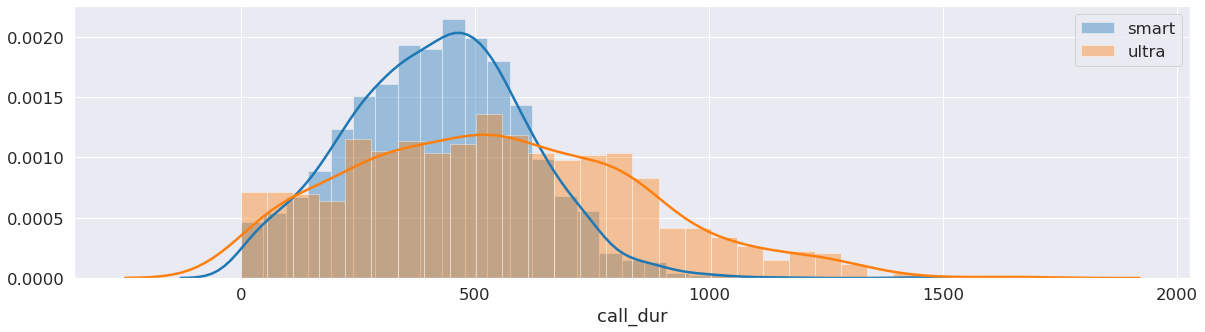

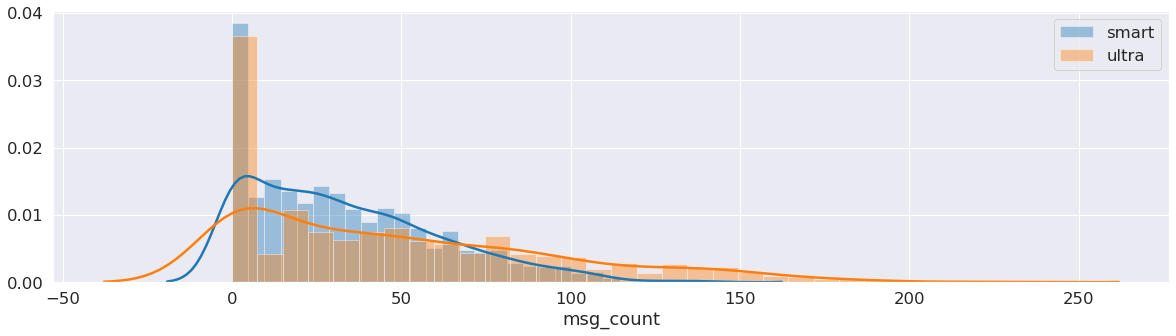

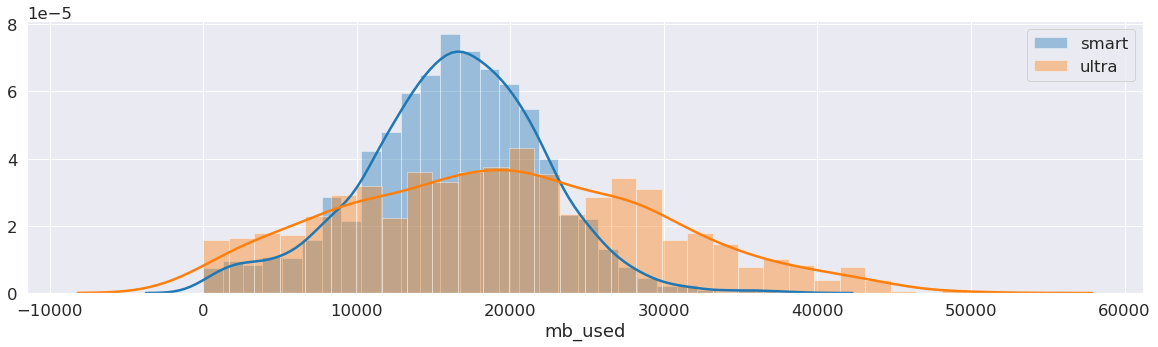

In [44]:
my_hist(user_by_month)

 Графики подтверждают выводы в предварительной части анализа. Тариф ultra дает более пологое распределение активности пользователей на основных метриках. 
Если попытаться как-то характеризовать полученные изображения, то я бы отметил следующее:
- `call_dur` - оба тарифа показывают нормальное распределение данных, но есть и отличия. Видно, что тариф smart тяготеет в правую сторону от среднего значения. 
- `msg_count` - это явное распределение пуассона. И похоже, что данной услугой (отправка сообщений) пользователи пользуются все реже и реже. 
- `mb_used`- оба тарифа показывают нормальное распределение данных

Основной вывод по итогам данного раздела анализа:
- средний пользователь тарифа ultra чаще использует телефон, чем пользователь тарифа smart. Очень хорошо видна разница в средних значениях основных метрик (длина звонка, количество сообщений, объем интернет трафика)
- также стоит отметить, что пользователи тарифа ultra более равномерно распределены на графиках по основным метрикам.  Оба тарифа показывают нормальное распределение данных (кроме сообщений), но у тарифа smart распределение более пологое 
- очевидно, что услуга отправки сообщений становится все менее популярной у пользователей и это не зависит от используемого тарифного плана.

## Построение гипотез и проверка

Цель данного блока работы понять:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается?
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов?

Так как нам доступны не все данные по пользователям (выборка), то для ответа на поставленные задачи придется прибегнуть к статистической проверке гипотез 

### Задача: сравнить выручку по тарифам

Сформулирую гипотезы:
- __нулевая__: средняя выручка пользователей по тарифам равна
- __альтернативная__: средняя выручка пользователей по тарифам не равна

In [45]:
smart = user_by_month[user_by_month['tariff']=='smart']['profit']
ultra = user_by_month[user_by_month['tariff']=='ultra']['profit']

smart_mean = user_by_month[user_by_month['tariff']=='smart']['profit'].mean()
ultra_mean = user_by_month[user_by_month['tariff']=='ultra']['profit'].mean()

print(smart_mean, ultra_mean)

1230.072424651372 2060.5678233438484


Критический уровень статистической значимости решил принять в 5%. Если я правильно понял теорию, то это стандарт. Если p-value окажется меньше данного значения - это будет означать, что нулевая гипотеза должна быть отвергнута. В качестве само проверки) проверить гипотезы несколькими вариантами.

#### вариант 1: среднее генеральной совокупности равно конкретному значению
Сравниваю массив данных по тарифу smart с фиксированным средним значением ultra_mean

In [46]:
alpha = .05

results = st.ttest_1samp(
    smart, 
    ultra_mean)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


#### вариант 2: средние двух генеральных совокупностей равны между собой

In [47]:
alpha = .05

results = st.ttest_ind(
    smart, 
    ultra)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.234262274932118e-186
Отвергаем нулевую гипотезу


### Задача: сравнить выручку по географии пользователей

Сформулирую гипотезы:
- __нулевая__: средняя выручка пользователей из Москвы равна пользователям других регионов
- __альтернативная__: средняя выручка пользователей из Москвы не равна пользователям других регионов

Для ответа на поставленный вопрос обновлю таблицу `users_by_mont` и добавлю в нее города, а потом сформирую массивы для оценки гипотез

In [48]:
merge_table = (user_by_month
               .merge(users[['user_id', 'city']], on=['user_id'], how='left')
              )
users_moscow = merge_table[merge_table['city']=='москва']['profit']
users_other = merge_table[merge_table['city']!='москва']['profit']

users_moscow_mean = merge_table[merge_table['city']=='москва']['profit'].mean()
users_other_mean = merge_table[merge_table['city']!='москва']['profit'].mean()

In [49]:
alpha = .05

results = st.ttest_ind(
    users_moscow, 
    users_other)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4052595766461483
Не получилось отвергнуть нулевую гипотезу


Получается (если я все сделал правильно), что на основании имеющихся данных (выборки) можно сделать вывод о средних значениях дохода с пользователя во всей генеральной совокупности. И вывод состоит в том, что средний доход у тарифа `smart` не равен среднему доходу тарифа `ultra`. Собственно и в самих выборках это наглядно и очевидно.

In [50]:
print('Средний доход тарифа smart на пользователя: {:.2f} руб.\n'
     'Средний доход тарифа ultra на пользователя: {:.2f} руб.'.format(smart_mean, ultra_mean))

Средний доход тарифа smart на пользователя: 1230.07 руб.
Средний доход тарифа ultra на пользователя: 2060.57 руб.


А вот географическое обитание пользователя не оказывает влияния на среднюю выручку. Нулевую гипотезу не получилось отвергнуть, а это означает, что в генеральной совокупности средняя выручка в Москве примерно равна средней выручке в других регионах. Для косвенного контроля можно посмотреть на средние значения в выборке.

In [51]:
print('Средний доход на пользователя из Москвы: {:.2f} руб.\n'
     'Средний доход на пользователя не из Москвы: {:.2f} руб.'.format(users_moscow_mean, users_other_mean))

Средний доход на пользователя из Москвы: 1502.69 руб.
Средний доход на пользователя не из Москвы: 1473.25 руб.


## Итоговый выводы

In [52]:
user_by_month.pivot_table(index='tariff', aggfunc={'profit':['count', 'sum', 'mean']})

profit                        
         count         mean        sum
tariff                                
smart   2223.0  1230.072425  2734451.0
ultra    951.0  2060.567823  1959600.0

В абсолютных цифрах тариф `ultra` принес меньше денег чем `smatr`. Но если оценивать эффективность с точки зрения прибыли на одного пользователя, то получится, что:
- тариф `ultra` более прибыльный чем `smart` (в 1,6 раз)
- количество пользователей на тарифе `ultra` меньше чем на smart (в 2,3 раза)

Поэтому, если целью комнат «Мегалайт» является увеличение прибыли, то я бы рекомендовал перераспределить рекламные бюджеты в пользу тарифа `ultra`. В предоставленных для анализа данных нет информации по стоимости привлечения пользователя на том или ином тарифе, но в свете текущих значений тариф `ultra` выглядит более привлекательным с точки зрения прибыли на одного пользователя.

Так же стоит отметить, что раз средний доход на пользователя не зависит от его региона проживания, то возможно стоит сконцентрировать маркетинговые усилия по продвижению тарифа `ultra` не региональных пользователей (не Москва). Скорее всего привлечение таких пользователей будет обходиться дешевле чем в Москве, а это означает уменьшение затрат и рост прибыли. 